### Other Code
- not used

In [ ]:
# import torch
# import torch.nn as nn
# from data_utils import get_train_loader, get_val_loader, get_test_loader, set_seed
# from baseline_transformer_architecture import create_small_transformer
# from modeling_functions import validate_transformer
# from optimizer_scheduler import get_optimizer, get_plateau_scheduler, linear_teacher_scheduler
# from tokenizers import Tokenizer
# from tqdm.auto import tqdm
# import json
# import matplotlib.pyplot as plt
# from rouge_score import rouge_scorer

# # === Simple token-level dropout ===
# def random_token_dropout(input_ids, dropout_prob=0.1, pad_token_id=1):
#     keep_mask = (torch.rand_like(input_ids.float()) > dropout_prob).long()
#     return input_ids * keep_mask + pad_token_id * (1 - keep_mask)

# if __name__ == "__main__":
#     torch.cuda.empty_cache()
#     set_seed(42)
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     config = {
#         "vocab_size": 20000,
#         "dropout": 0.1,
#         "d_model": 384,
#         "nhead": 6,
#         "num_encoder_layers": 4,
#         "num_decoder_layers": 4,
#         "dim_feedforward": 1536
#     }

#     tokenizer = Tokenizer.from_file("cnn_bpe_tokenizer_20k.json")
#     pad_idx = tokenizer.token_to_id("[PAD]")

#     model = create_small_transformer(**config).to(device)
#     optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
#     plateau_scheduler = get_plateau_scheduler(optimizer)
#     teacher_scheduler = linear_teacher_scheduler
#     criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

#     scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

#     train_loader = get_train_loader(tokenizer, batch_size=32, num_workers=2)
#     val_loader = get_val_loader(tokenizer, batch_size=4, num_workers=0)
#     test_loader = get_test_loader(tokenizer, batch_size=4, num_workers=0)

#     history = {
#         "train_loss": [],
#         "val_loss": [],
#         "train_rouge": [],
#         "val_rouge": [],
#         "test_loss": None,
#         "test_rouge": None,
#         "learning_rate": [],
#         "teacher_forcing_ratio": [],
#     }

#     def compute_rouge(reference_ids, prediction_ids):
#         refs = [tokenizer.decode(r.tolist(), skip_special_tokens=True) for r in reference_ids]
#         preds = [tokenizer.decode(p.tolist(), skip_special_tokens=True) for p in prediction_ids]
#         scores = [scorer.score(r, p)["rougeL"].fmeasure for r, p in zip(refs, preds)]
#         return sum(scores) / len(scores)

#     for epoch in range(2):
#         model.train()
#         total_loss = 0
#         predictions, references = [], []
#         tf_ratio = teacher_scheduler.step()

#         for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/5"):
#             input_ids = batch["input_ids"].to(device)
#             labels = batch["labels"].to(device)
#             attn_mask = batch["attention_mask"].to(device)

#             input_ids_aug = random_token_dropout(input_ids, dropout_prob=0.1, pad_token_id=pad_idx)

#             optimizer.zero_grad()
#             output = model(
#                 src=input_ids_aug,
#                 tgt=labels,
#                 src_key_padding_mask=(attn_mask == 0),
#                 teacher_forcing_ratio=tf_ratio
#             )
#             logits = output.view(-1, output.size(-1))
#             targets = labels[:, 1:].contiguous().view(-1)
#             loss = criterion(logits, targets)
#             loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
#             optimizer.step()
#             total_loss += loss.item()

#             with torch.no_grad():
#                 predictions.append(output.argmax(dim=-1))
#                 references.append(labels[:, 1:])

#         avg_train_loss = total_loss / len(train_loader)
#         train_rouge = compute_rouge(torch.cat(references), torch.cat(predictions))

#         torch.cuda.empty_cache()
#         val_loss, val_outputs = validate_transformer(model, val_loader, criterion, tokenizer, device, pad_idx, max_length_generate=40)
#         val_rouge = compute_rouge(val_outputs["references"], val_outputs["predictions"])

#         history["train_loss"].append(avg_train_loss)
#         history["val_loss"].append(val_loss)
#         history["train_rouge"].append(train_rouge)
#         history["val_rouge"].append(val_rouge)
#         history["learning_rate"].append(optimizer.param_groups[0]['lr'])
#         history["teacher_forcing_ratio"].append(tf_ratio)

#         plateau_scheduler.step(val_loss)
#         print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ROUGE: {train_rouge:.4f}, Val ROUGE: {val_rouge:.4f}")

#     # === Final Test Evaluation ===
#     torch.cuda.empty_cache()
#     model.eval()
#     total_test_loss = 0
#     predictions, references = [], []

#     with torch.no_grad():
#         for batch in test_loader:
#             input_ids = batch["input_ids"].to(device)
#             labels = batch["labels"].to(device)
#             attn_mask = batch["attention_mask"].to(device)

#             output = model(
#                 src=input_ids,
#                 tgt=labels,
#                 src_key_padding_mask=(attn_mask == 0)
#             )
#             logits = output.view(-1, output.size(-1))
#             targets = labels[:, 1:].contiguous().view(-1)
#             loss = criterion(logits, targets)
#             total_test_loss += loss.item()

#             pred_ids = output.argmax(dim=-1)
#             predictions.append(pred_ids)
#             references.append(labels[:, 1:])

#     avg_test_loss = total_test_loss / len(test_loader)
#     test_rouge = compute_rouge(torch.cat(references), torch.cat(predictions))

#     history["test_loss"] = avg_test_loss
#     history["test_rouge"] = test_rouge

#     print(f"\nTest Loss: {avg_test_loss:.4f} | Test ROUGE-L: {test_rouge:.4f}")

#     with open("label_smooth_history.json", "w") as f:
#         json.dump(history, f, indent=2)

#     epochs = list(range(1, len(history["train_loss"]) + 1))

#     # === Loss Plot ===
#     plt.figure(figsize=(10, 5))
#     plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
#     plt.plot(epochs, history["val_loss"], label="Validation Loss", marker="s")
#     plt.axhline(y=history["test_loss"], color='r', linestyle='--', label=f"Test Loss: {history['test_loss']:.4f}")
#     plt.title("Loss Over Epochs")
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.savefig("loss_plot.png")
#     plt.show()

#     # === ROUGE Plot ===
#     plt.figure(figsize=(10, 5))
#     plt.plot(epochs, history["train_rouge"], label="Train ROUGE-L", marker="o")
#     plt.plot(epochs, history["val_rouge"], label="Validation ROUGE-L", marker="s")
#     plt.axhline(y=history["test_rouge"], color='g', linestyle='--', label=f"Test ROUGE-L: {history['test_rouge']:.4f}")
#     plt.title("ROUGE-L Over Epochs")
#     plt.xlabel("Epoch")
#     plt.ylabel("ROUGE-L F1 Score")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.savefig("rouge_plot.png")
#     plt.show()

### Import Libraries

In [10]:
# Import libraries
import torch
import torch.nn as nn
from data_utils import get_train_loader, get_val_loader, get_test_loader, set_seed
from baseline_transformer_architecture import create_small_transformer
from modeling_functions import validate_transformer, generate_with_beam_search, calculate_and_save_rouge
from optimizer_scheduler import get_plateau_scheduler, linear_teacher_scheduler, get_optimizer
from visualization import visualize_training_dynamics, load_history

from tokenizers import Tokenizer
from tqdm.auto import tqdm
import json
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from torch.optim.lr_scheduler import LambdaLR

### Training and Validation Phase
- Test phase is separated due to long computation time with beam search strategy.

In [7]:
# === Simple token-level dropout ===
def random_token_dropout(input_ids, dropout_prob=0.1, pad_token_id=1):
    keep_mask = (torch.rand_like(input_ids.float()) > dropout_prob).long()
    return input_ids * keep_mask + pad_token_id * (1 - keep_mask)

# === ROUGE scoring for training/test sets ===
def compute_rouge(reference_ids, prediction_ids):
    refs = [tokenizer.decode(r.tolist(), skip_special_tokens=True) for r in reference_ids]
    preds = [tokenizer.decode(p.tolist(), skip_special_tokens=True) for p in prediction_ids]
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    for r, p in zip(refs, preds):
        result = scorer.score(r, p)
        for k in scores:
            scores[k].append(result[k].fmeasure)
    return {k: sum(v)/len(v) if v else 0.0 for k, v in scores.items()}

# === Main code section ===
if __name__ == "__main__":
    torch.cuda.empty_cache()
    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # == Model Configuration ==
    filename = "data_aug"
    config = {
        "vocab_size": 20000,
        "dropout": 0.1,
        # "max_len": 512,
        "d_model": 512,
        "nhead": 8,
        "num_encoder_layers": 4,
        "num_decoder_layers": 4,
        "dim_feedforward": 2048
    }

    tokenizer = Tokenizer.from_file("cnn_bpe_tokenizer_20k.json")
    pad_idx = tokenizer.token_to_id("[PAD]")

    model = create_small_transformer(**config).to(device)
    optimizer = get_optimizer(model)
    plateau_scheduler = get_plateau_scheduler(optimizer)
    teacher_scheduler = linear_teacher_scheduler
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

    train_loader = get_train_loader(tokenizer, batch_size=64, num_workers=4)
    val_loader = get_val_loader(tokenizer, batch_size=64, num_workers=2)
    test_loader = get_test_loader(tokenizer, batch_size=64, num_workers=2)
    
    # What is stored
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_rouge1": [],
        "train_rouge2": [],
        "train_rougeL": [],
        "rouge1": [], # validation rouge scores (named this way for visualization formatting)
        "rouge2": [],
        "rougeL": [],
        "learning_rate": [],
        "teacher_forcing_ratio": [],
        "global_step": 0
    }
    
    start_epoch = 0

    # Warmup scheduler configuration
    warmup_steps = 1 * len(train_loader)  # 1 epochs of batches
    initial_lr = 5e-5
    target_lr = 2e-4
    
    # Scaling from 5e-5 to 2e-4
    warmup_scheduler = LambdaLR(
    optimizer,
    lr_lambda=lambda step: (initial_lr + (target_lr - initial_lr) * min(1.0, step / warmup_steps))/ target_lr
    )
    
    for epoch in range(5):
        
        # === Training Phase ===
        model.train()
        total_loss = 0
        predictions, references = [], []
        epoch_train_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/5"):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attn_mask = batch["attention_mask"].to(device)
            
            if epoch < 2:
                tf_ratio = 0.9  # Warmup phase, keep the same
            else:
                tf_ratio = teacher_scheduler.step()

            input_ids_aug = random_token_dropout(input_ids, dropout_prob=0.1, pad_token_id=pad_idx)

            optimizer.zero_grad()
            
            output = model(
                src=input_ids_aug,
                tgt=labels,
                src_key_padding_mask=(attn_mask == 0),
                teacher_forcing_ratio=tf_ratio
            )
            
            logits = output.view(-1, output.size(-1))
            targets = labels[:, 1:].contiguous().view(-1)
            loss = criterion(logits, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            optimizer.step()
            total_loss += loss.item()
            
            history['global_step'] += 1
                
            # Learning rate warmup setting
            if history['global_step'] < warmup_steps:
                warmup_scheduler.step()

            with torch.no_grad():
                predictions.append(output.argmax(dim=-1))
                references.append(labels[:, 1:])

        avg_train_loss = total_loss / len(train_loader)
        train_rouge_scores = compute_rouge(torch.cat(references), torch.cat(predictions))

        torch.cuda.empty_cache()
        
        # === Validation Phase ===
        val_loss, val_rouge_scores = validate_transformer(
            model, val_loader, criterion, tokenizer, device, pad_idx, max_length_generate=40)
        
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(val_loss)
        history["learning_rate"].append(optimizer.param_groups[0]['lr'])
        history["teacher_forcing_ratio"].append(tf_ratio)

        for k in ["rouge1", "rouge2", "rougeL"]:
            history[f"train_{k}"].append(train_rouge_scores[k])
            history[f"{k}"].append(val_rouge_scores[f"{k}_mean"])
            
        # Update history and schedulers
        if epoch >= 2:
            plateau_scheduler.step(val_loss)

        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")
        for k in ["rouge1", "rouge2", "rougeL"]:
            print(f"  Train {k.upper()}: {train_rouge_scores[k]:.4f}, Val {k.upper()}: {val_rouge_scores[f'{k}_mean']:.4f}")
    
    # Final save
    torch.save(model.state_dict(), f"{filename}_final_model.pt")
    with open(f"{filename}_history.json", 'w') as f:
        json.dump(history, f, indent=4)

    # # === Final Test Evaluation ===
    # torch.cuda.empty_cache()
    # model.eval()
    # total_test_loss = 0
    # predictions, references = [], []

    # with torch.no_grad():
    #     for batch in test_loader:
    #         input_ids = batch["input_ids"].to(device)
    #         labels = batch["labels"].to(device)
    #         attn_mask = batch["attention_mask"].to(device)

    #         output = model(
    #             src=input_ids,
    #             tgt=labels,
    #             src_key_padding_mask=(attn_mask == 0)
    #         )
    #         logits = output.view(-1, output.size(-1))
    #         targets = labels[:, 1:].contiguous().view(-1)
    #         loss = criterion(logits, targets)
    #         total_test_loss += loss.item()

    #         pred_ids = output.argmax(dim=-1)
    #         predictions.append(pred_ids)
    #         references.append(labels[:, 1:])

    # avg_test_loss = total_test_loss / len(test_loader)
    # test_rouge_scores = compute_rouge(torch.cat(references), torch.cat(predictions))
    # history["test_loss"] = avg_test_loss
    # for k in ["rouge1", "rouge2", "rougeL"]:
    #     history[f"test_{k}"] = test_rouge_scores[k]
    #     print(f"Test {k.upper()}: {test_rouge_scores[k]:.4f}")

    # with open("data_augmentation_history.json", "w") as f:
    #     json.dump(history, f, indent=2)

    # epochs = list(range(1, len(history["train_loss"]) + 1))

    # # === Loss Plot ===
    # plt.figure(figsize=(10, 5))
    # plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    # plt.plot(epochs, history["val_loss"], label="Validation Loss", marker="s")
    # plt.axhline(y=history["test_loss"], color='r', linestyle='--', label=f"Test Loss: {history['test_loss']:.4f}")
    # plt.title("Loss Over Epochs")
    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.savefig("data_aug_loss_plot.png")
    # plt.show()

    # # === ROUGE Score Plots ===
    # for k in ["rouge1", "rouge2", "rougeL"]:
    #     plt.figure(figsize=(10, 5))
    #     plt.plot(epochs, history[f"train_{k}"], label=f"Train {k.upper()}", marker="o")
    #     plt.plot(epochs, history[f"val_{k}"], label=f"Validation {k.upper()}", marker="s")
    #     plt.axhline(y=history[f"test_{k}"], color='r', linestyle='--', label=f"Test {k.upper()}: {history[f'test_{k}']:.4f}")
    #     plt.title(f"{k.upper()} Over Epochs")
    #     plt.xlabel("Epoch")
    #     plt.ylabel(f"{k.upper()} F1 Score")
    #     plt.legend()
    #     plt.grid(True)
    #     plt.tight_layout()
    #     plt.savefig(f"{k}_data_aug_plot.png")
    #     plt.show()


Epoch 1/5: 100%|██████████| 4487/4487 [21:46<00:00,  3.43it/s] 
/home/catherine/anaconda3/envs/torch_env/lib/python3.9/site-packages/torch/nn/modules/transformer.py:408: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608883701/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


[Epoch 1] Train Loss: 6.3273, Val Loss: 5.4048
  Train ROUGE1: 0.1712, Val ROUGE1: 0.1307
  Train ROUGE2: 0.0137, Val ROUGE2: 0.0148
  Train ROUGEL: 0.1421, Val ROUGEL: 0.1102


Epoch 2/5: 100%|██████████| 4487/4487 [21:43<00:00,  3.44it/s] 


[Epoch 2] Train Loss: 5.3871, Val Loss: 4.8983
  Train ROUGE1: 0.2281, Val ROUGE1: 0.1463
  Train ROUGE2: 0.0269, Val ROUGE2: 0.0187
  Train ROUGEL: 0.1858, Val ROUGEL: 0.1220


Epoch 3/5: 100%|██████████| 4487/4487 [27:42<00:00,  2.70it/s] 


[Epoch 3] Train Loss: 5.1371, Val Loss: 4.7101
  Train ROUGE1: 0.2415, Val ROUGE1: 0.1444
  Train ROUGE2: 0.0328, Val ROUGE2: 0.0175
  Train ROUGEL: 0.1970, Val ROUGEL: 0.1169


Epoch 4/5: 100%|██████████| 4487/4487 [39:30<00:00,  1.89it/s]  


[Epoch 4] Train Loss: 5.2308, Val Loss: 4.6182
  Train ROUGE1: 0.2282, Val ROUGE1: 0.1564
  Train ROUGE2: 0.0320, Val ROUGE2: 0.0184
  Train ROUGEL: 0.1871, Val ROUGEL: 0.1229


Epoch 5/5: 100%|██████████| 4487/4487 [49:15<00:00,  1.52it/s]  


[Epoch 5] Train Loss: 5.3544, Val Loss: 4.5337
  Train ROUGE1: 0.2143, Val ROUGE1: 0.1565
  Train ROUGE2: 0.0299, Val ROUGE2: 0.0185
  Train ROUGEL: 0.1765, Val ROUGEL: 0.1265


### Visualize Train and Validation Results

Saved training dynamics plot to data_aug_losses_wide.png


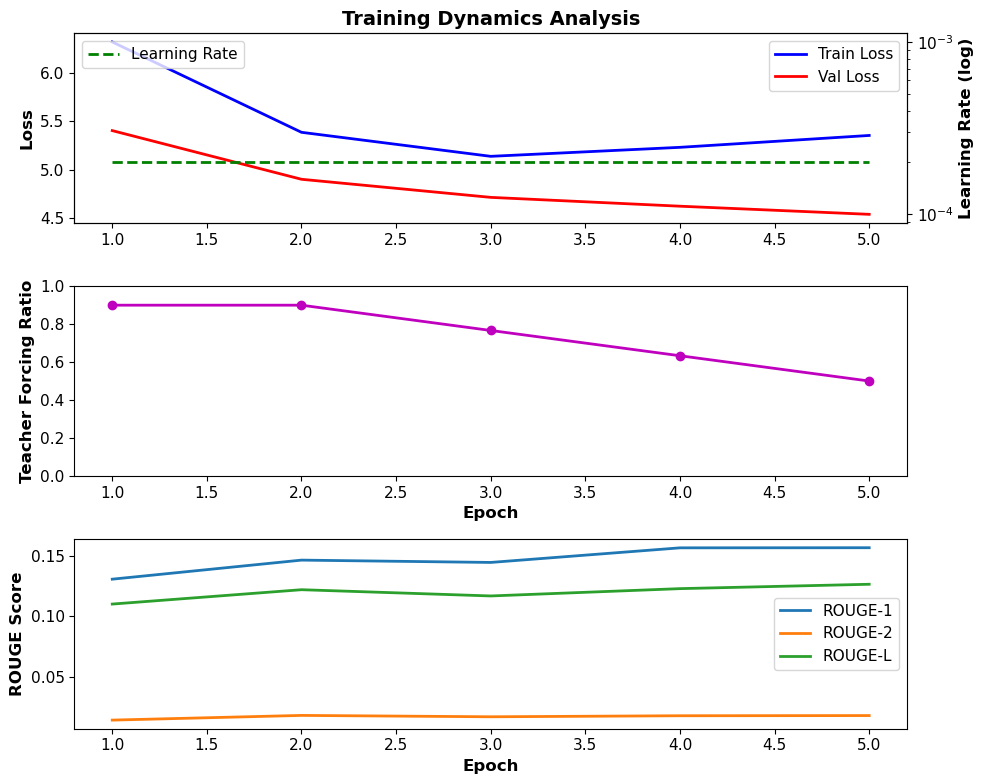

In [8]:
# load data
history = load_history("data_aug_history.json")
visualize_training_dynamics(history, save_path="data_aug_losses_wide.png")

### Inference with Test Set

In [11]:
# libraries for inference
from pathlib import Path

def main():
    # 1. Configuration setup
    set_seed(42)
    config = {
        "vocab_size": 20000,
        "dropout": 0.1,
        "d_model": 512,
        "nhead": 8,
        "num_encoder_layers": 4,
        "num_decoder_layers": 4,
        "dim_feedforward": 2048
    }

    # 2. Initialize with automatic GPU selection
    tokenizer = Tokenizer.from_file("cnn_bpe_tokenizer_20k.json")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Auto-select GPU
    output_dir = Path("data_aug_inf_results")
    output_dir.mkdir(exist_ok=True)

    # 3. Model setup with MAXIMUM optimization
    model = create_small_transformer(**config).to(device)
    model.load_state_dict(torch.load('data_aug_final_model.pt'))
    model.eval()
    
    # 4. ULTIMATE performance optimizations
    torch.backends.cuda.enable_flash_sdp(True)
    torch.backends.cuda.enable_mem_efficient_sdp(True)
    torch.set_float32_matmul_precision('high')
    torch.backends.cuda.enable_math_sdp(True)  # Fallback option
    
    # 5. Data loader with optimized settings
    test_loader = get_test_loader(
        tokenizer,
        batch_size=64,  # Adjusted for your GPU
        num_workers=2   # Increased from 2
        # pin_memory=True  # Faster data transfer
    )

    # 6. SUPERCHARGED inference pipeline
    generated_summaries = []
    reference_summaries = []
    demo_examples = []
    demo_count = 5
    
    with torch.no_grad(), torch.cuda.amp.autocast():
        for batch_idx, batch in enumerate(tqdm(test_loader, desc="Processing batches")):
            # Memory management
            if batch_idx % 10 == 0:
                torch.cuda.empty_cache()
                
            # Get batch data
            input_ids = batch['input_ids'].to(device, non_blocking=True)  # shape: [64, seq_len]
            labels = batch['labels'].to(device, non_blocking=True)
            
            # Process EACH sequence in the batch
            batch_summaries = []
            for seq_idx in range(input_ids.size(0)):  # Loop through batch dimension
                summary = generate_with_beam_search(
                    model=model,
                    input_ids=input_ids[seq_idx],  # Pass individual sequence
                    tokenizer=tokenizer,
                    device=device,
                    beam_width=3,
                    max_length=40
                )
                batch_summaries.append(summary)
            
            # Store results
            generated_summaries.extend(batch_summaries)
            batch_references = [tokenizer.decode(label.tolist(), skip_special_tokens=True) 
                            for label in labels]
            reference_summaries.extend(batch_references)
            
            # Save examples
            if len(demo_examples) < demo_count:
                for i in range(min(len(batch_summaries), demo_count - len(demo_examples))):
                    demo_examples.append({
                        "input": tokenizer.decode(input_ids[i].tolist(), skip_special_tokens=True)[:200] + "...",
                        "generated": batch_summaries[i],
                        "reference": batch_references[i]
                    })
                    
    # 7. Save outputs
    rouge_results = calculate_and_save_rouge(
        generated_summaries=generated_summaries,
        reference_summaries=reference_summaries,
        output_path=str(output_dir/"data_aug_rouge_scores.json")
    )
    
    with open(output_dir/"data_aug_demo_examples.json", 'w') as f:
        json.dump(demo_examples, f, indent=2)
    
    print("\nResults saved to:")
    print(f"- Full ROUGE scores: {output_dir/'data_aug_rouge_scores.json'}")
    print(f"- Example summaries: {output_dir/'data_aug_demo_examples.json'}")
    print(f"\nProcessed {len(generated_summaries)} samples (Batch size=64, Workers=2)")

if __name__ == "__main__":
    main()

Processing batches: 100%|██████████| 180/180 [44:42<00:00, 14.91s/it]



Results saved to:
- Full ROUGE scores: data_aug_inf_results/data_aug_rouge_scores.json
- Example summaries: data_aug_inf_results/data_aug_demo_examples.json

Processed 11490 samples (Batch size=64, Workers=2)
